### Machine Learning
Лектор: Елена Кантонистова

Факультет экономических наук НИУ ВШЭ, 2018-19 учебный год

Домашнее задание №3
Задание основано на материалах курса Practical DL

Вам необходимо решить задачу классификации изображений размера 32x32 на 10 классов с помощью нейронных сетей и PyTorch. Для достижения высокого качества рекомендуется применять сверточные нейронные сети. Формально, мы разрешаем использовать любые сети, кроме предобученных.

Система оценивания
Ваша оценка зависит от скора на тесте:

<40% (0 баллов)
40% (4 балла)
50% (5 баллов)
60% (6 баллов)
65% (7 баллов)
70% (8 баллов)
75% (9 баллов)
80% (10 баллов)

CIFAR dataset
60k изображений размером 3x32x32
10 классов: planes, dogs, cats, trucks, etc.

In [1]:
""" Загружаем библиотеки """
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.datasets as datasets

In [2]:
print(torch.__version__)

1.0.0


In [3]:
print(torchvision.__version__)

0.2.1


In [4]:
""" Функции для скачивания и предобработки CIFAR 10 """

"""cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict


def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    return X_train,y_train,X_val,y_val,X_test,y_test

In [ ]:
""" Скачивание CIFAR 10"""
download_cifar10("./cifar10",
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',)

In [5]:
"""Загружаем CIFAR 10 и сразу бьём на обучающую&тестовую 80:20"""
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10(data_path="./cifar10", channels_last=False, test_size=0.2, random_state=1337)

In [6]:
class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


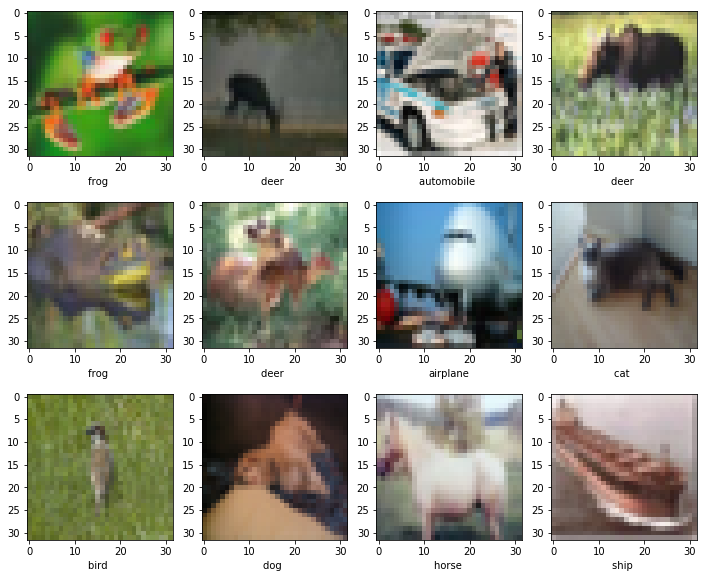

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [53]:
"""Построение модели"""
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
model.add_module('batchnorm1', nn.BatchNorm2d(10))
model.add_module("relu1", nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2, 2))
model.add_module('conv2', nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3))
model.add_module('batchnorm2', nn.BatchNorm2d(20))
model.add_module("relu12", nn.ReLU())
model.add_module('pool12', nn.MaxPool2d(2, 2))
model.add_module('flatten', Flatten())
model.add_module('dense1', nn.Linear(720, 100)) 
model.add_module("relu2", nn.ReLU()) 
model.add_module("dropout1", nn.Dropout(0.1))
model.add_module('dense2', nn.Linear(100, 10)) 

In [54]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

Тьюним гиперпараметры 

In [76]:
num_epochs = 15 # total amount of full passes over training data
batch_size = 20  # number of samples processed in one SGD iteration
opt = torch.optim.SGD(model.parameters(), lr=0.01, nesterov=True, momentum=0.9)
train_loss = []
val_accuracy = []

In [13]:
import time

In [77]:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 15 took 70.286s
  training loss (in-iteration): 	1.128667
  validation accuracy: 			61.76 %
Epoch 2 of 15 took 68.459s
  training loss (in-iteration): 	1.037305
  validation accuracy: 			64.78 %
Epoch 3 of 15 took 68.776s
  training loss (in-iteration): 	0.971340
  validation accuracy: 			65.39 %
Epoch 4 of 15 took 67.211s
  training loss (in-iteration): 	0.916401
  validation accuracy: 			65.78 %
Epoch 5 of 15 took 68.588s
  training loss (in-iteration): 	0.874411
  validation accuracy: 			64.04 %
Epoch 6 of 15 took 105.549s
  training loss (in-iteration): 	0.832662
  validation accuracy: 			67.83 %
Epoch 7 of 15 took 72.327s
  training loss (in-iteration): 	0.798833
  validation accuracy: 			67.59 %
Epoch 8 of 15 took 70.916s
  training loss (in-iteration): 	0.766728
  validation accuracy: 			66.67 %
Epoch 9 of 15 took 71.217s
  training loss (in-iteration): 	0.740131
  validation accuracy: 			66.46 %
Epoch 10 of 15 took 70.326s
  training loss (in-iteration): 	0.710419
  

### Final test

In [78]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(Variable(torch.FloatTensor(X_batch)))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("10 баллов. Если все верно, пора писать статью по сверточным сетям.")
elif test_accuracy * 100 > 90:
    print("10 баллов. У вас есть шанс стать ассистентом на следующий год")
elif test_accuracy * 100 > 80:
    print("10 баллов. ")
elif test_accuracy * 100 > 75:
    print("9 баллов")
elif test_accuracy * 100 > 70:
    print("8 баллов")
elif test_accuracy * 100 > 65:
    print("7 баллов")
elif test_accuracy * 100 > 60:
    print("6 баллов")
elif test_accuracy * 100 > 50:
    print("5 баллов")
elif test_accuracy * 100 > 40:
    print("4 балла")
else:
    print("0 баллов. Нужно больше магии.")

Final results:
  test accuracy:		66.61 %
7 баллов
